# MIPソルバーの時間制限依存性に関する数値実験

ここではOMMXでサポートされているPySCIPOptを用い、MIPソルバーの時間制限依存性に関する数値実験を行いましょう。
MINTOはOMMXメッセージをネイティブにサポートしているため、OMMXを通して数値実験をスムーズに行うことができます。

<!-- # Numerical Experiments on Time Limit Dependency of MIP Solver

In this notebook, we will conduct numerical experiments on the time limit dependency of MIP solvers using PySCIPOpt, which is supported by OMMX.
MINTO natively supports OMMX Message, allowing us to smoothly perform numerical experiments through OMMX. Let's give it a try. -->

In [1]:
import minto
import ommx_pyscipopt_adapter as scip_ad
from ommx.dataset import miplib2017

ベンチマークターゲットとして、miplib2017からインスタンスを取得しましょう。
`ommx.dataset`を用いれば、簡単に取得することができます。

<!-- In this tutorial, we will pick up an instance from miplib2017 as a benchmark target. We can easily obtain miplib2017 instances using ommx.dataset. -->

In [2]:
instance_name = "reblock115"
instance = miplib2017(instance_name)

`ommx_pyscipopt_adapter`を用いてommx.v1.InstanceをPySCIPOptのモデルに変換し、制限値/時間パラメータを変化させながら実験を行います。
ommxインスタンスと解は、MINTOの`.log_*`メソッドを用いて保存できます。
この数値実験では単一のインスタンスを使用するため、withブロックの外にある`experiment`空間に保存します。
制限時間ごとに解は変化するため、withブロック内(`run`空間内)に保存されます。

<!-- Using the ommx_pyscipopt_adapter, we convert ommx.v1.Instance to PySCIPOpt's Model and conduct experiments by varying the limits/time parameter.

The ommx instance and solution can be saved using MINTO's `.log_*` methods. Since we're using a single instance that doesn't change throughout this numerical experiment, we store it in the `experiment` space outside the with block. 
Solutions are saved within the with block (in the `run` space) since they vary for each time limit. -->

In [3]:
timelimit_list = [0.1, 0.5, 1, 2]


experiment = minto.Experiment(auto_saving=False)

experiment.log_global_instance(instance_name, instance)
adapter = scip_ad.OMMXPySCIPOptAdapter(instance)
scip_model = adapter.solver_input

for timelimit in timelimit_list:
    with experiment.run() as run:
        run.log_parameter("timelimit", timelimit)

        # Solve by SCIP
        scip_model.setParam("limits/time", timelimit)
        scip_model.optimize()
        solution = adapter.decode(scip_model)

        run.log_solution("scip", solution)


[2025-08-05 09:46:40] 🚀 Starting experiment '7e3c433d'
[2025-08-05 09:46:40]   ├─ 📊 Environment: OS: Darwin 24.5.0, CPU: Apple M2 (8 cores), Memory: 24.0 GB, Python: 3.11.11
[2025-08-05 09:46:40]   ├─ 📊 Environment Information
[2025-08-05 09:46:40]       ├─ OS: Darwin 24.5.0
[2025-08-05 09:46:40]       ├─ Platform: macOS-15.5-arm64-arm-64bit
[2025-08-05 09:46:40]       ├─ CPU: Apple M2 (8 cores)
[2025-08-05 09:46:40]       ├─ Memory: 24.0 GB
[2025-08-05 09:46:40]       ├─ Architecture: arm64
[2025-08-05 09:46:40]       ├─ Python: 3.11.11
[2025-08-05 09:46:40]       ├─ Virtual Environment: /Users/yuyamashiro/workspace/minto/.venv
[2025-08-05 09:46:40]       ├─ Key Package Versions:
[2025-08-05 09:46:40]   ├─ 🏃 Created run #0
[2025-08-05 09:46:40]       ├─ 📝 Parameter: timelimit = 0.1
[2025-08-05 09:46:40]       ├─ 🎯 Solution 'scip': objective: 0.000, feasible: True
[2025-08-05 09:46:40]   ├─ ✅ Run #0 completed (0.1s)
[2025-08-05 09:46:40]   ├─ 🏃 Created run #1
[2025-08-05 09:46:40]     

`.get_run_table`メソッドを用いてommx.Solutionをpandas.DataFrameに変換すると、解の主要な情報のみが表示されます。
実際の解オブジェクトにアクセスしたい場合は、`experiment.dataspaces.run_datastores[run_id].solutions`から参照することができます。

<!-- When converting ommx.Solution to pandas.DataFrame using the `.get_run_table` method, only the main information of the solution is displayed. If you want to access the actual solution objects, you can reference them from `experiment.dataspaces.run_datastores[run_id].solutions`. -->

In [4]:
runs_table = experiment.get_run_table()
runs_table

solution_scip                                            parameter  \
           objective feasible optimality relaxation start  name timelimit   
run_id                                                                      
0       0.000000e+00     True          0          0  None  scip       0.1   
1      -2.824191e+07     True          0          0  None  scip       0.5   
2      -2.824191e+07     True          0          0  None  scip       1.0   
3      -2.824191e+07     True          0          0  None  scip       2.0   

       metadata               
         run_id elapsed_time  
run_id                        
0             0     0.110397  
1             1     0.410168  
2             2     0.506859  
3             3     1.008944

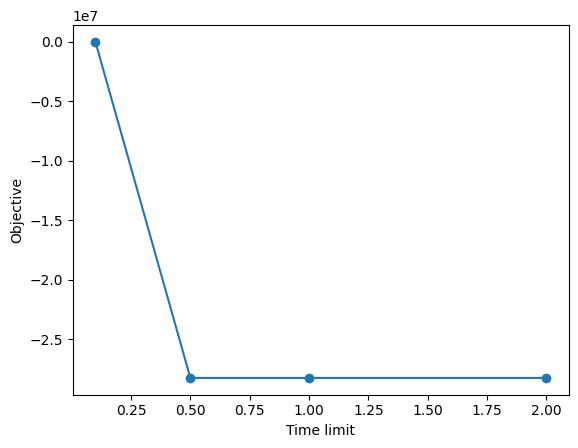

In [5]:
import matplotlib.pyplot as plt

x = runs_table["parameter", "timelimit"]
y = runs_table["solution_scip", "objective"]
plt.plot(x, y, "o-")
plt.xlabel("Time limit")
plt.ylabel("Objective")
plt.show()

MINTOはネイティブにOMMXをサポートしているため、pandas.DataFrameに表示されるときは、主要な量のみが表示されます。
このため、統計分析を簡単に実行することができます。

<!-- As MINTO natively supports OMMX, only the main quantities are displayed when shown in a pandas.DataFrame, making it easy to perform statistical analysis. -->